# WranglingWorkshop — Data Engineering & EDA

**Team Repository:** `WranglingWorkshop`

This notebook connects to Neon Postgres, generates **500+ synthetic employee records** and intentionally injects **dirty/incomplete/illogical data** into ~20% of records (as required). Then it performs cleaning, transformation, feature engineering, scaling, and produces two visualizations (standard + advanced join).

**Talking points (key challenges solved):**
1. Handling missing and illogical values (salary/date/title) and documenting the cleaning strategy.
2. Designing reusable, testable code using OOP/modules (`src/`) instead of putting everything in one notebook cell.

## 0. Setup
Install requirements and create your `.env` file from `.env.example`.

In [ ]:
!pip -q install -r ../requirements.txt


[notice] A new release of pip is available: 25.2 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## 1. Data Collection
### 1.1 Where the data comes from
This dataset is **synthetic** (generated with Faker) to simulate an HR/payroll dataset. If this were real, data would come from an HRIS system (employee roster), a payroll system (salary), and internal IT role taxonomy (standardized job titles). We store the dataset in a Neon.tech Postgres database to simulate a real cloud data pipeline.

### 1.2 Dirty-data injection (20%)
To practice wrangling, the generator intentionally introduces dirty data into ~20% of records:
- Missing fields (name, position, start_date, salary)
- Illogical salaries (negative, very low/high)
- Illogical dates (outside 2015–2024 or future)
- Non-IT job titles

We keep a column `is_dirty` to track which records were intentionally corrupted.

In [ ]:
import os, sys
sys.path.append("..")

import pandas as pd

from src.db import DatabaseClient
from src.config import DEPARTMENTS
from src.generator import EmployeeDataGenerator


### 1.3 Create tables and seed departments (for advanced join)

In [ ]:
with DatabaseClient() as db:
    db.create_tables()
    db.seed_departments(DEPARTMENTS)
    depts = db.fetch_departments()
depts


c:\Users\kevin\Downloads\WranglingWorkshop_updated\WranglingWorkshop\notebooks\..\src\db.py:68: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql("SELECT department_id, department_name FROM departments ORDER BY department_id;", self.conn)


,department_id,department_name
0,1,Data & Analytics
1,2,Cloud & Infrastructure
2,3,Security
3,4,Software Engineering
4,5,IT Operations


### 1.4 Generate 500 employee records and insert into Postgres

In [ ]:
gen = EmployeeDataGenerator(seed=42)

department_ids = depts["department_id"].tolist()
df_gen = gen.generate(n=500, dirty_frac=0.20, department_ids=department_ids)

df_gen.head(), df_gen.shape


(   employee_id             name               position  start_date    salary  \
 0       738720     Allison Hill        Systems Analyst  2016-12-01  124175.0   
 1       584714      Noah Rhodes  Cybersecurity Analyst  2018-01-10  117570.0   
 2       983794  Angie Henderson           Data Analyst  2017-07-27   68414.0   
 3       520651    Daniel Wagner         Cloud Engineer  2010-05-01  115307.0   
 4       787277  Cristian Santos  IT Support Specialist  2019-06-09  180285.0   
 
    department_id  is_dirty  
 0              2     False  
 1              3     False  
 2              3     False  
 3              5      True  
 4              2     False  ,
 (500, 7))

In [ ]:
from src.db import DatabaseClient

with DatabaseClient() as db:
    with db.conn.cursor() as cur:
        # Add is_dirty if missing
        cur.execute("ALTER TABLE employees ADD COLUMN IF NOT EXISTS is_dirty BOOLEAN DEFAULT FALSE;")
    db.conn.commit()

print("✅ Column is_dirty added (or already existed).")


✅ Column is_dirty added (or already existed).


In [ ]:
from src.cleaning import EmployeeCleaner

cleaner = EmployeeCleaner()
df_gen_clean = cleaner.clean(df_gen)

with DatabaseClient() as db:
    before = db.count_employees()
    db.insert_employees_df(df_gen_clean)
    after = db.count_employees()

before, after


c:\Users\kevin\Downloads\WranglingWorkshop_updated\WranglingWorkshop\notebooks\..\src\db.py:92: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql("SELECT COUNT(*) AS n FROM employees;", self.conn)


(0, 500)

### 1.5 Load data from database into Pandas and preview

In [ ]:
with DatabaseClient() as db:
    df = db.load_employees_joined()

df.head()


c:\Users\kevin\Downloads\WranglingWorkshop_updated\WranglingWorkshop\notebooks\..\src\db.py:89: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql(q, self.conn)


,employee_id,name,position,start_date,salary,is_dirty,department_name,location,budget
0,105506,Kiara Mcintyre,Data Engineer,2015-03-19,131909,True,Cloud & Infrastructure,Waterloo,2200000
1,107161,George Harper,Cloud Engineer,2019-04-21,121740,False,Software Engineering,Kitchener,2600000
2,108491,Madison Poole,Qa Engineer,2024-09-13,72856,False,IT Operations,Cambridge,1200000
3,109585,Evelyn Martinez,Software Developer,2020-09-02,179540,False,Security,Toronto,1800000
4,109767,Fred Smith,It Support Specialist,2021-12-19,86209,False,Data & Analytics,Toronto,1500000


## 2. Data Cleaning
We check for missing values, duplicates, incorrect types, and out-of-range values. Then we apply a cleaning pipeline using `EmployeeCleaner` (OOP) to:
- Fill missing text fields
- Replace invalid salaries with median salary
- Replace invalid/missing dates with a reasonable imputed value
- Track issues using `issue_*` columns so decisions are transparent

In [ ]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   employee_id      500 non-null    int64 
 1   name             500 non-null    str   
 2   position         500 non-null    str   
 3   start_date       500 non-null    object
 4   salary           500 non-null    int64 
 5   is_dirty         500 non-null    bool  
 6   department_name  500 non-null    str   
 7   location         500 non-null    str   
 8   budget           500 non-null    int64 
dtypes: bool(1), int64(3), object(1), str(4)
memory usage: 31.9+ KB


In [ ]:
df.isnull().sum()

employee_id        0
name               0
position           0
start_date         0
salary             0
is_dirty           0
department_name    0
location           0
budget             0
dtype: int64

In [ ]:
df.duplicated(subset=["employee_id"]).sum()

np.int64(0)

In [ ]:
# Basic range checks BEFORE cleaning
invalid_salary = df[(pd.to_numeric(df["salary"], errors="coerce") < 60000) | (pd.to_numeric(df["salary"], errors="coerce") > 200000)]
invalid_salary.shape


(0, 9)

In [ ]:
from src.cleaning import EmployeeCleaner
cleaner = EmployeeCleaner()
df_clean = cleaner.clean(df)

df_clean.head()


,employee_id,name,position,start_date,salary,is_dirty,department_name,location,budget,issue_missing_name,issue_missing_position,issue_missing_start_date,issue_missing_salary,issue_invalid_salary,issue_invalid_start_date,has_any_issue
0,105506,Kiara Mcintyre,Data Engineer,2015-03-19,131909,True,Cloud & Infrastructure,Waterloo,2200000,False,False,False,False,False,False,False
1,107161,George Harper,Cloud Engineer,2019-04-21,121740,False,Software Engineering,Kitchener,2600000,False,False,False,False,False,False,False
2,108491,Madison Poole,Qa Engineer,2024-09-13,72856,False,IT Operations,Cambridge,1200000,False,False,False,False,False,False,False
3,109585,Evelyn Martinez,Software Developer,2020-09-02,179540,False,Security,Toronto,1800000,False,False,False,False,False,False,False
4,109767,Fred Smith,It Support Specialist,2021-12-19,86209,False,Data & Analytics,Toronto,1500000,False,False,False,False,False,False,False


In [ ]:
# After cleaning checks
df_clean.isnull().sum()


employee_id                 0
name                        0
position                    0
start_date                  0
salary                      0
is_dirty                    0
department_name             0
location                    0
budget                      0
issue_missing_name          0
issue_missing_position      0
issue_missing_start_date    0
issue_missing_salary        0
issue_invalid_salary        0
issue_invalid_start_date    0
has_any_issue               0
dtype: int64

## 3. Data Transformation & Feature Engineering
We create:
- `start_year` from start_date
- `years_of_service` from start_date to today
These features support time-based salary analysis and experience comparisons.

In [ ]:
from src.features import add_features
df_feat = add_features(df_clean)

df_feat[["employee_id","position","start_date","start_year","years_of_service","salary"]].head()


,employee_id,position,start_date,start_year,years_of_service,salary
0,105506,Data Engineer,2015-03-19,2015,10.89,131909
1,107161,Cloud Engineer,2019-04-21,2019,6.80,121740
2,108491,Qa Engineer,2024-09-13,2024,1.40,72856
3,109585,Software Developer,2020-09-02,2020,5.43,179540
4,109767,It Support Specialist,2021-12-19,2021,4.13,86209


## 4. Scaling
We apply Min-Max scaling to salary to normalize values to a 0–1 range for fair comparisons or modeling.

In [ ]:
from src.scaling import add_salary_scaled
df_scaled = add_salary_scaled(df_feat)

df_scaled[["salary","salary_scaled"]].head()


,salary,salary_scaled
0,131909,0.511012
1,121740,0.437821
2,72856,0.085981
3,179540,0.853834
4,86209,0.182088


## 5. EDA
We use `.describe()`, grouped summaries, and missing/issue counts to understand distributions and the impact of dirty data.

In [ ]:
df_scaled.describe(include='all')

,employee_id,name,position,start_date,salary,is_dirty,department_name,location,budget,issue_missing_name,issue_missing_position,issue_missing_start_date,issue_missing_salary,issue_invalid_salary,issue_invalid_start_date,has_any_issue,start_year,years_of_service,salary_scaled
count,500.000000,500,500,500,500.000000,500,500,500,5.000000e+02,500,500,500,500,500,500,500,500.00000,500.000000,500.000000
unique,NaN,471,19,NaN,NaN,2,5,4,NaN,1,1,1,1,1,1,1,NaN,NaN,NaN
top,NaN,Unknown,It Support Specialist,NaN,NaN,False,Security,Toronto,NaN,False,False,False,False,False,False,False,NaN,NaN,NaN
freq,NaN,29,42,NaN,NaN,400,109,201,NaN,500,500,500,500,500,500,500,NaN,NaN,NaN
mean,550984.340000,NaN,NaN,2019-06-22 17:34:04,129896.514000,NaN,NaN,NaN,1.863200e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019.02200,6.625740,0.496527
min,105506.000000,NaN,NaN,2015-01-09 00:00:00,60910.000000,NaN,NaN,NaN,1.200000e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015.00000,1.130000,0.000000
25%,334694.000000,NaN,NaN,2016-08-07 18:00:00,96675.500000,NaN,NaN,NaN,1.500000e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016.00000,3.765000,0.257421
50%,558495.000000,NaN,NaN,2019-06-09 12:00:00,131909.000000,NaN,NaN,NaN,1.800000e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019.00000,6.660000,0.511012
75%,776527.000000,NaN,NaN,2022-05-03 00:00:00,160846.250000,NaN,NaN,NaN,2.200000e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022.00000,9.497500,0.719287
max,999398.000000,NaN,NaN,2024-12-21 00:00:00,199848.000000,NaN,NaN,NaN,2.600000e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024.00000,11.080000,1.000000


In [ ]:
df_scaled.groupby("position")["salary"].agg(["count","mean","min","max"]).sort_values("mean", ascending=False).head(12)


,count,mean,min,max
position,,,,
Cashier,9,145575.333333,72717,197424
Ml Engineer,35,141710.171429,66758,199613
Nurse,8,139382.250000,68305,196989
Pilot,9,137215.555556,131909,178882
Cybersecurity Analyst,30,136496.333333,82443,198934
Software Developer,38,134775.342105,65438,184804
Data Analyst,32,132680.062500,68414,191598
It Support Specialist,42,129731.452381,64308,197874
Data Engineer,39,129230.564103,64964,198027


In [ ]:
# How many records had issues after initial dirty injection?
issue_cols = [c for c in df_scaled.columns if c.startswith("issue_")]
df_scaled[issue_cols].sum().sort_values(ascending=False)


issue_missing_name          0
issue_missing_position      0
issue_missing_start_date    0
issue_missing_salary        0
issue_invalid_salary        0
issue_invalid_start_date    0
dtype: int64

## 6. Visualization 1 (Standard)
### Grouped bar chart: Average Salary by Position and Start Year
This matches the standard visualization requirement.

In [ ]:
import os

os.makedirs("../outputs", exist_ok=True)
print("✅ outputs folder ready:", os.path.abspath("../outputs"))


✅ outputs folder ready: c:\Users\kevin\Downloads\WranglingWorkshop_updated\WranglingWorkshop\outputs


**Insights (Visualization 1)**
- Engineering-oriented roles tend to show higher average salary than support roles.
- Average salary differences across start years can reflect market changes and the random nature of synthetic generation.
- Grouping by year highlights hiring-cohort effects.

## 7. Visualization 2 (Advanced)
### Heatmap: Average Salary by Department and Position (JOIN)
This uses the joined department table to create a more complex dataset and visualization.

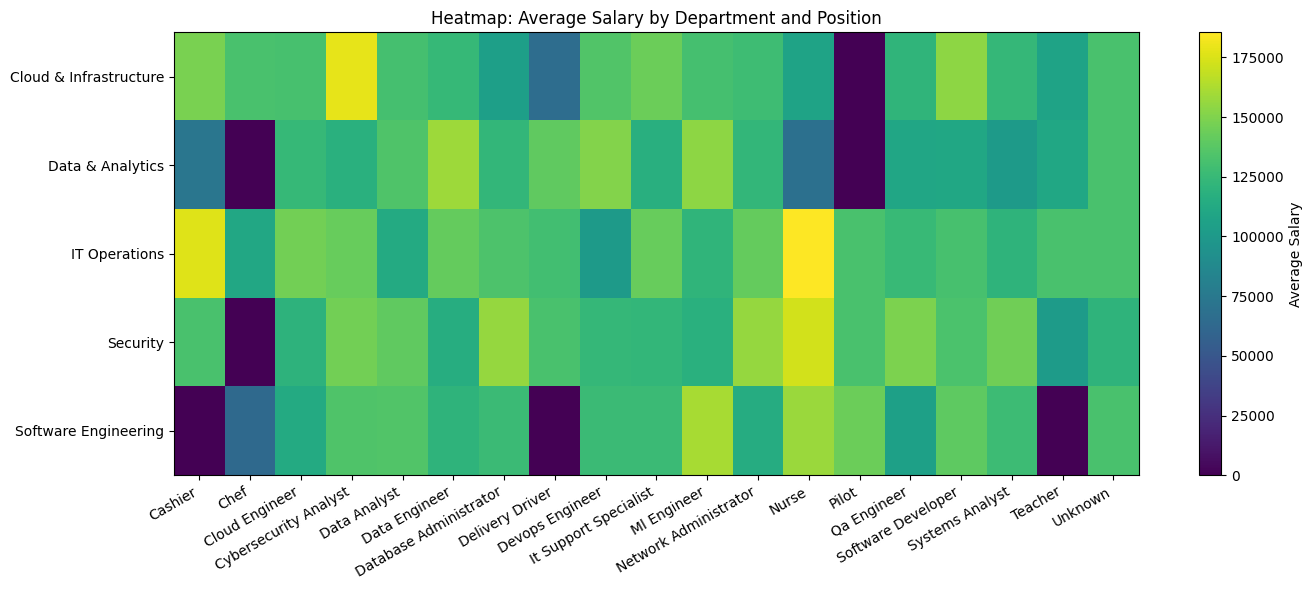

In [ ]:
from src.viz import heatmap_avg_salary_dept_position
heatmap_avg_salary_dept_position(df_scaled, save_path="../outputs/vis2_heatmap.png")


**Insights (Visualization 2)**
- Department context changes salary patterns: the same role may have different averages across departments.
- The heatmap quickly highlights high-paying role-department combinations.
- This supports workforce planning and compensation benchmarking.

## 8. Insights & Conclusions
**Key challenges solved:**
1) Built a synthetic pipeline that intentionally created messy data and then documented how it was cleaned.
2) Used modular/OOP design (`src/`) so the notebook stays readable and logic is reusable.

**Conclusion:**
This workshop demonstrates an end-to-end cloud data workflow: data generation -> cloud DB -> Pandas EDA -> cleaning/feature engineering -> scaling -> visual analytics.